<a href="https://colab.research.google.com/github/juelha/IANNWTF/blob/sabine/Homework_05_Sabine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Data set
As CNNs are very fashionable, in this week we would like you to work with the Fashion
MNIST Dataset.
Note that this is very similar to the MNIST dataset that you have already seen in
notebooks on courseware. The images have the same shape and there are the same
number of classes.
1.1 Construct a Data Pipeline
Make yourself familiar with the dataset and construct a Data Pipeline. Perform all the
preprocessing steps that you deem necessary. 12


In [9]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math


(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# normalise pixel values 
train_images = train_images /  255.0
test_images = test_images / 255.0
validation_images = train_images[:5000]
validation_labels = train_labels[:5000]

assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

#train_dataset = tf.concat([train_images, train_labels], 1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def preprocessing(tensor):
  tensor = tensor.map(lambda images, labels: (tf.expand_dims(images, -1), tf.one_hot(labels, 10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  tensor = tensor.cache()
  #shuffle, batch, prefetch
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  #return preprocessed dataset
  return tensor

train_dataset = train_dataset.apply(preprocessing)
test_dataset = test_dataset.apply(preprocessing)


# 2 Model
Although the basic procedure of defining a CNN Model is the same, you will need to
use entirely different layers this week. We want you to experiment a bit with how to
structure your CNN but here are some general hints:
• You may want to alternate between convolutional layers and pooling layers. 3
• Find the middle ground between the depth of the network and the number of filters
used in each layer. Maybe consider the idea of the receptive field when deciding
on the parameters. 4
• Find the right parameters for the layers.5
• As this is an image classification task, make sure to have a classifier architecture
following your convolutional and pooling operations. 6

A kernel size of 3, no stride and ’same’ padding usually is a good starting point. For filter sizes, we
didn’t use more than 64 filters per layer, but feel free to experiment (be aware of lengthy training times
though)

Apply Global Average Pooling followed by a Dense layer with the number of units depending on
your number of classes. Use a softmax activation.



In [10]:
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28))
        self.maxpooling1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.maxpooling2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        #flatten layer global average or max pooling
        self.flatten = tf.keras.layers.GlobalMaxPooling2D()
        self.dense1 = tf.keras.layers.Dense(10, activation='softmax')


    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpooling1(x)
        x = self.conv2(x)
        x = self.maxpooling2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x
    

In [ ]:
# Receptive Field Size 



# 3 Training 

Start by training your network for 10 epochs using a learning rate of 0.1. You can
again copy most of the training procedure from previous scripts. 7 You may use all the
optimization and regularization techniques that you wish and find applicable.
To pass this task, achieve at least an accuracy of 85% on the test dataset. 8



In [13]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [14]:
# Put everything together

'''
Then train your network for 10 epochs using a learning rate of 0.1. As a loss use the
categorical cross entropy. As an optimizer use SGD.
'''

tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
#train_dataset = train_dataset.take(1000)
#test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)


# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')
    
    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Train Losses: {train_loss}, Test Losses: {test_loss}')

Epoch: 0 starting with accuracy 0.0994408945686901
Train Losses: 0.2571730315685272, Test Losses: 0.38099825382232666
Epoch: 1 starting with accuracy 0.8616214057507987
Train Losses: 0.2558862864971161, Test Losses: 0.33777713775634766
Epoch: 2 starting with accuracy 0.87689696485623
Train Losses: 0.11835536360740662, Test Losses: 0.3318798542022705
Epoch: 3 starting with accuracy 0.8782947284345048
Train Losses: 0.3854769170284271, Test Losses: 0.2863708436489105
Epoch: 4 starting with accuracy 0.8962659744408946
Train Losses: 0.15222887694835663, Test Losses: 0.28284886479377747
Epoch: 5 starting with accuracy 0.900758785942492
Train Losses: 0.10465922951698303, Test Losses: 0.2784772217273712
Epoch: 6 starting with accuracy 0.9022563897763578
Train Losses: 0.15338842570781708, Test Losses: 0.25975656509399414
Epoch: 7 starting with accuracy 0.9072484025559105
Train Losses: 0.06908796727657318, Test Losses: 0.26980772614479065
Epoch: 8 starting with accuracy 0.9035543130990416
Train 

# Receptive Field Size 
Compute the receptive field size of the final layer of your convolutional Neural
Network. Provide step by step computations with explanations to follow what and
why you are doing these computational steps. Does your receptive field size cover
the whole input region / a sufficiently large enough region of the input to perform
the task? In doubt, incorporate your findings to adjust your network architecture
to boost up the accuracy.

• Optional: As later you will have to deal with more complex architectures to actually analytically compute the receptive field size, you may want to try and automatize the process. Feel free to come up with your own algorithm / way of doing so
or for example make use of this library.


In [ ]:
 def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28))
        self.maxpooling1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.maxpooling2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        #flatten layer global average or max pooling
        self.flatten = tf.keras.layers.GlobalMaxPooling2D()
        self.dense1 = tf.keras.layers.Dense(10, activation='softmax'

In [28]:

#Compute input size that leads to a 1x1 output size, among other things   
# [filter size, stride, padding]

conv_net = {
    'conv1': [3,1,1],
    'pool1': [2,1,0],
    'conv2': [3,1,1],
    'pool2': [2,1,0],
    'conv3': [3,1,1],
    'dense1': [1,1,0]
}

class ReceptiveFieldCalculator():
    def calculate(self, architecture, input_image_size):
        input_layer = ('input_layer', input_image_size, 3, 1, 1.5)
        self._print_layer_info(input_layer)
        
        for key in architecture:
            current_layer = self._calculate_layer_info(architecture[key], input_layer, key)
            self._print_layer_info(current_layer)
            input_layer = current_layer
            
    def _print_layer_info(self, layer):
        print(f'------')
        print(f'{layer[0]}: n = {layer[1]}; r = {layer[2]}; j = {layer[3]}; start = {layer[4]}')     
        print(f'------')
            
    def _calculate_layer_info(self, current_layer, input_layer, layer_name):
        n_in = input_layer[1]
        j_in = input_layer[2]
        r_in = input_layer[3]
        start_in = input_layer[4]
        
        k = current_layer[0]
        s = current_layer[1]
        p = current_layer[2]

        n_out = math.floor((n_in - k + 2*p)/s) + 1
        padding = (n_out-1)*s - n_in + k 
        p_right = math.ceil(padding/2)
        p_left = math.floor(padding/2)

        j_out = j_in * s
        r_out = r_in + (k - 1)*j_in
        start_out = start_in + ((k-1)/2 - p_left)*j_in
        return layer_name, n_out, j_out, r_out, start_out

calculator = ReceptiveFieldCalculator()
calculator.calculate(conv_net, 28)

------
input_layer: n = 28; r = 3; j = 1; start = 1.5
------
------
conv1: n = 28; r = 3; j = 7; start = 1.5
------
------
pool1: n = 27; r = 3; j = 10; start = 3.0
------
------
conv2: n = 27; r = 3; j = 16; start = 3.0
------
------
pool2: n = 26; r = 3; j = 19; start = 4.5
------
------
conv3: n = 26; r = 3; j = 25; start = 4.5
------
------
dense1: n = 26; r = 3; j = 25; start = 4.5
------


#4 Visualization
Visualize accuracy and loss for training and test data using matplotlib.


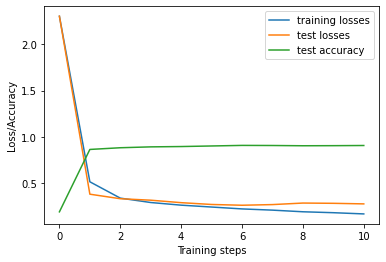

In [ ]:
# Visualisations

import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training losses","test losses", "test accuracy"))
plt.show()

In [ ]:
'''
Baselines: 
Epoch 1/10
1875/1875 [==============================] - 25s 8ms/step - loss: 0.4923 - accuracy: 0.8175 - val_loss: 0.3930 - val_accuracy: 0.8581
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3233 - accuracy: 0.8822 - val_loss: 0.3101 - val_accuracy: 0.8890
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2773 - accuracy: 0.8984 - val_loss: 0.3073 - val_accuracy: 0.8878
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2472 - accuracy: 0.9084 - val_loss: 0.2738 - val_accuracy: 0.8996
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2271 - accuracy: 0.9158 - val_loss: 0.2704 - val_accuracy: 0.9029
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2034 - accuracy: 0.9240 - val_loss: 0.2629 - val_accuracy: 0.9026
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1861 - accuracy: 0.9309 - val_loss: 0.2653 - val_accuracy: 0.9041
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1698 - accuracy: 0.9368 - val_loss: 0.2725 - val_accuracy: 0.9077
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1565 - accuracy: 0.9411 - val_loss: 0.2815 - val_accuracy: 0.9086
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1435 - accuracy: 0.9459 - val_loss: 0.2812 - val_accuracy: 0.9108
'''


'''
# receptive field code 

from receptivefield.image import get_default_image
from receptivefield.keras import KerasReceptiveField

# define model function
def model_build_func(input_shape):
    act = 'linear' # see Remarks
    inp = Input(shape=input_shape, name='input_image')
    x = Conv2D(32, (7, 7), activation=act)(inp)
    x = Conv2D(32, (5, 5), activation=act)(x)
    x = AvgPool2D()(x)
    x = Conv2D(64, (5, 5), activation=act, name='feature_grid')(x)
    x = AvgPool2D()(x)
    model = Model(inp, x)
    return model

shape = [64, 64, 3]
# compute receptive field
rf = KerasReceptiveField(model_build_func, init_weights=True)
rf_params = rf.compute(shape, 'input_image', ['feature_grid'])
# debug receptive field
rf.plot_rf_grids(get_default_image(shape, name='doge'))
'''

"\n# receptive field code \n\nfrom receptivefield.image import get_default_image\nfrom receptivefield.keras import KerasReceptiveField\n\n# define model function\ndef model_build_func(input_shape):\n    act = 'linear' # see Remarks\n    inp = Input(shape=input_shape, name='input_image')\n    x = Conv2D(32, (7, 7), activation=act)(inp)\n    x = Conv2D(32, (5, 5), activation=act)(x)\n    x = AvgPool2D()(x)\n    x = Conv2D(64, (5, 5), activation=act, name='feature_grid')(x)\n    x = AvgPool2D()(x)\n    model = Model(inp, x)\n    return model\n\nshape = [64, 64, 3]\n# compute receptive field\nrf = KerasReceptiveField(model_build_func, init_weights=True)\nrf_params = rf.compute(shape, 'input_image', ['feature_grid'])\n# debug receptive field\nrf.plot_rf_grids(get_default_image(shape, name='doge'))\n"